# Telecom X – Parte 2: Prevendo Churn

## **Objetivo**: construir um pipeline de Machine Learning completo para prever evasão (Churn), reaproveitando o pré-processamento da Parte 1 e contemplando os requisitos do challenge:



In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)
from joblib import dump


try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMB = True
except Exception:
    HAS_IMB = False

sns.set_theme(style='whitegrid')
RANDOM_STATE = 42


## 1. Carregamento dos dados

In [60]:
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'
df_raw = pd.read_json(url)
df_raw.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2. Pré‑processamento (reaproveitando a Parte 1, **com comentários**)
**Passos**: expandir colunas aninhadas, padronizar strings, tratar vazios, converter tipos, binarizar `Churn`, unificar textos, definir categóricas, dropar `customerID` (irrelevante p/ modelo).

In [61]:
# 2.1 – Expandir colunas aninhadas (valores que são dict → colunas novas)
df = df_raw.copy()
nested_cols = [c for c in df.columns if df[c].apply(type).eq(dict).all()]
for c in nested_cols:
    expanded = pd.json_normalize(df[c])
    expanded.columns = [f"{c}_{sub}" for sub in expanded.columns]
    df = pd.concat([df.drop(columns=[c]), expanded], axis=1)

# 2.2 – Conversões numéricas conhecidas
for col in ['account_Charges.Total', 'customer_tenure']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.3 – Padronizar strings (minúsculas/trim) exceto IDs
obj_cols = df.select_dtypes(include='object').columns.tolist()
if 'customerID' in obj_cols:
    obj_cols.remove('customerID')
for col in obj_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

# 2.4 – Strings vazias → NaN, depois dropna nestas colunas textuais
for col in obj_cols:
    df[col] = df[col].replace('', np.nan)
df = df.dropna(subset=obj_cols)

# 2.5 – Binarizar o alvo Churn (yes→1, no→0)
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'yes':1, 'no':0}).astype(int)

# 2.6 – Unificar textos como "no internet service"/"no phone service" → "no"
df = df.replace({'no internet service':'no', 'no phone service':'no'})

# 2.7 – Colunas binárias yes/no → booleano
bin_cols = [c for c in df.columns
            if df[c].nunique() == 2 and set(df[c].dropna().unique()).issubset({'yes','no'})]
for c in bin_cols:
    df[c] = df[c].map({'yes':True, 'no':False})

# 2.8 – Objetos restantes viram categóricos (exceto ID)
cat_cols_all = df.select_dtypes(include='object').columns.tolist()
if 'customerID' in cat_cols_all:
    cat_cols_all.remove('customerID')
for c in cat_cols_all:
    df[c] = df[c].astype('category')

# 2.9 – Remover coluna irrelevante
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

df.head()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0,female,0,True,True,9,True,False,dsl,False,True,False,True,True,False,one year,True,mailed check,65.6,593.30
1,0,male,0,False,False,9,True,True,dsl,False,False,False,False,False,True,month-to-month,False,mailed check,59.9,542.40
2,1,male,0,False,False,4,True,False,fiber optic,False,False,True,False,False,False,month-to-month,True,electronic check,73.9,280.85
3,1,male,1,True,False,13,True,False,fiber optic,False,True,True,False,True,True,month-to-month,True,electronic check,98.0,1237.85
4,1,female,1,True,False,3,True,False,fiber optic,False,False,False,True,True,False,month-to-month,True,mailed check,83.9,267.40


## 3. Verificação da **proporção** de Evasão (desbalanceamento)

Proporção de Churn (%):
 Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


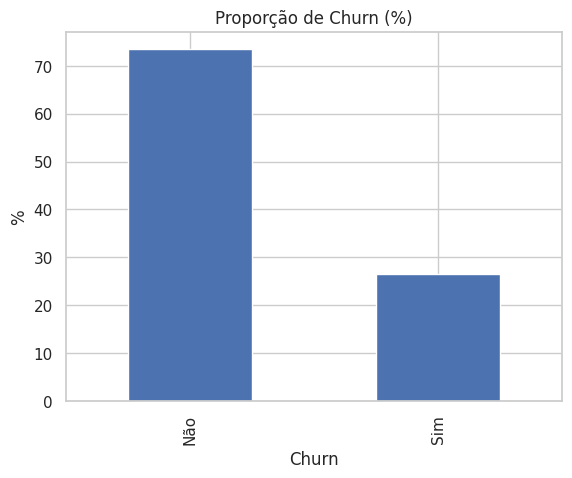

In [62]:
y_rate = df['Churn'].value_counts(normalize=True).mul(100).round(2)
print('Proporção de Churn (%):\n', y_rate)

ax = df['Churn'].replace({0:'Não',1:'Sim'}).value_counts(normalize=True).mul(100).plot.bar()
ax.set_title('Proporção de Churn (%)'); ax.set_ylabel('%'); plt.show()

## 4. Correlação entre variáveis **numéricas**

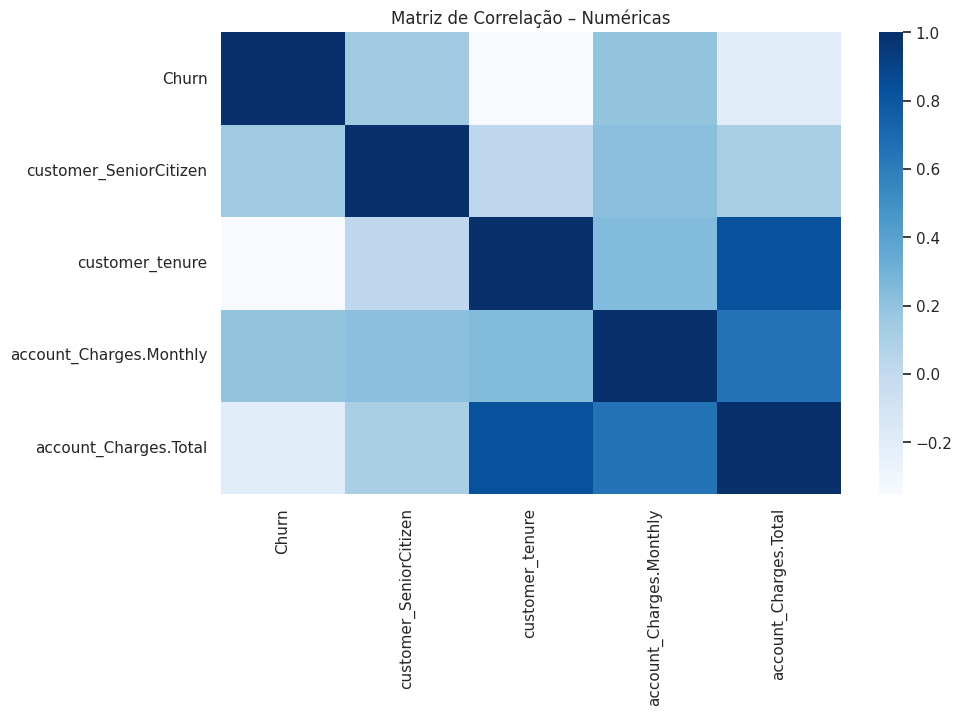

In [63]:
num_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(), annot=False, cmap='Blues')
plt.title('Matriz de Correlação – Numéricas')
plt.show()

## 5. Análises direcionadas

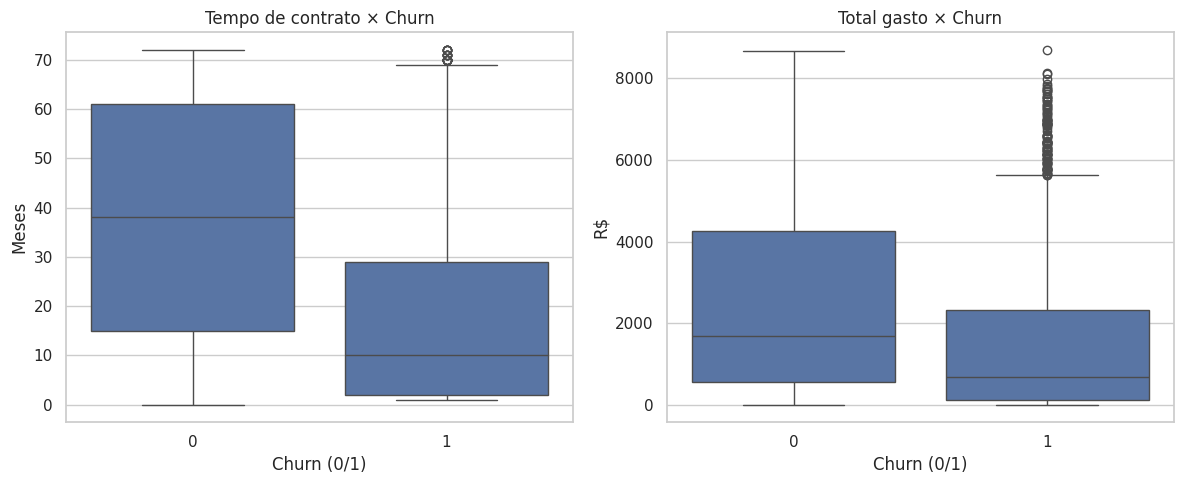

In [64]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='Churn', y='customer_tenure', ax=axes[0])
axes[0].set_title('Tempo de contrato × Churn')
axes[0].set_xlabel('Churn (0/1)')
axes[0].set_ylabel('Meses')

sns.boxplot(data=df, x='Churn', y='account_Charges.Total', ax=axes[1])
axes[1].set_title('Total gasto × Churn')
axes[1].set_xlabel('Churn (0/1)')
axes[1].set_ylabel('R$')

plt.tight_layout()
plt.show()


## 6. Separação em **Treino/Teste** (estratificada)

In [65]:


cols_descartar = []
if 'customerID' in df.columns:
    cols_descartar.append('customerID')

X = df.drop(columns=['Churn'] + cols_descartar).copy()
y = df['Churn'].copy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print('Shapes → X_train:', X_train.shape, '| X_test:', X_test.shape)


Shapes → X_train: (4930, 19) | X_test: (2113, 19)


## 7. `ColumnTransformer` (numéricas + categóricas)

In [66]:

import numpy as np
from pandas.api.types import is_bool_dtype

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer


num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if not is_bool_dtype(X_train[c])]

# Categóricas: tudo que não é numérico (inclui object, category e bool)
cat_cols = [c for c in X_train.columns if c not in num_cols]

print('numéricas:', len(num_cols), '| categóricas/bool:', len(cat_cols))
print('Exemplos categóricas:', [(c, str(X_train[c].dtype)) for c in cat_cols[:8]])

# === Transformadores ===
# (1) Numéricas: imputar mediana + padronizar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=False))   # seguro mesmo com esparsidade
])

# (2) Categóricas: converter 'category' -> object, imputar moda, One-Hot


to_object = FunctionTransformer(lambda X: X.astype('object'))

categorical_transformer = Pipeline(steps=[
    ('to_object', to_object),  # <-- converte 'category' para 'object'
    ('imputer',   SimpleImputer(strategy='most_frequent')),
    ('onehot',    OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# ColumnTransformer final
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ],
    remainder='drop'
)


numéricas: 4 | categóricas/bool: 15
Exemplos categóricas: [('customer_gender', 'category'), ('customer_Partner', 'bool'), ('customer_Dependents', 'bool'), ('phone_PhoneService', 'bool'), ('phone_MultipleLines', 'bool'), ('internet_InternetService', 'category'), ('internet_OnlineSecurity', 'bool'), ('internet_OnlineBackup', 'bool')]


## 8. Modelos + `GridSearchCV` (métrica: **ROC AUC**)

In [58]:

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 8.1 Regressão Logística
pipe_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=1000, solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE
    ))
])

param_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2']
}

gs_lr = GridSearchCV(
    pipe_lr, param_lr, scoring='roc_auc',
    cv=cv, n_jobs=-1, verbose=0, error_score='raise'
)
gs_lr.fit(X_train, y_train)
print("LR best AUC:", gs_lr.best_score_, "| params:", gs_lr.best_params_)

# 8.2 Random Forest
pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
])

param_rf = {
    'model__n_estimators': [150, 300],
    'model__max_depth': [None, 8, 12],
    'model__min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(
    pipe_rf, param_rf, scoring='roc_auc',
    cv=cv, n_jobs=-1, verbose=0, error_score='raise'
)
gs_rf.fit(X_train, y_train)
print("RF best AUC:", gs_rf.best_score_, "| params:", gs_rf.best_params_)


LR best AUC: 0.8461416266093718 | params: {'model__C': 1.0, 'model__penalty': 'l1'}
RF best AUC: 0.8449834104005929 | params: {'model__max_depth': 8, 'model__min_samples_split': 5, 'model__n_estimators': 300}


## 9. Avaliação no **Teste** (ACC, PREC, REC, F1, AUC, Matriz de Confusão, Curva ROC)

=== Desempenho no TESTE ===
Logistic Regression (best): ACC=0.735 | PREC=0.501 | REC=0.797 | F1=0.615 | AUC=0.841

Classification report:
               precision    recall  f1-score   support

           0      0.907     0.713     0.798      1552
           1      0.501     0.797     0.615       561

    accuracy                          0.735      2113
   macro avg      0.704     0.755     0.707      2113
weighted avg      0.799     0.735     0.750      2113



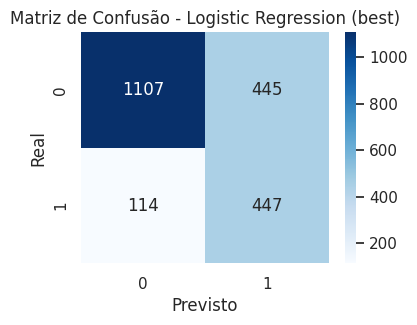

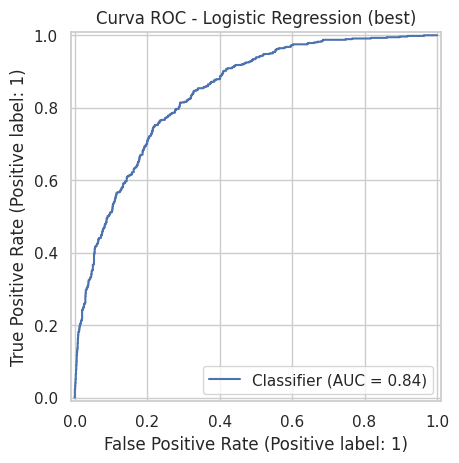

Random Forest (best): ACC=0.760 | PREC=0.534 | REC=0.756 | F1=0.626 | AUC=0.841

Classification report:
               precision    recall  f1-score   support

           0      0.896     0.762     0.823      1552
           1      0.534     0.756     0.626       561

    accuracy                          0.760      2113
   macro avg      0.715     0.759     0.725      2113
weighted avg      0.800     0.760     0.771      2113



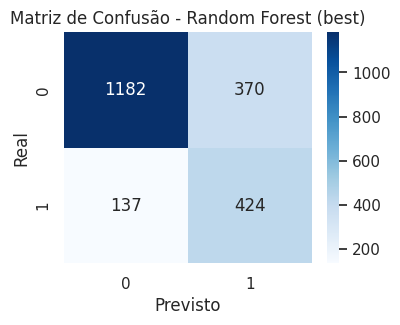

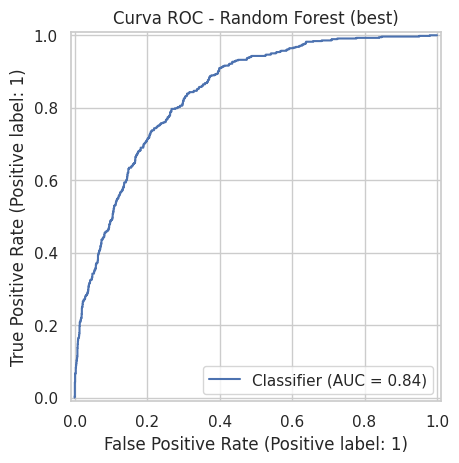

In [67]:
def evaluate(model, X_test, y_test, title='Modelo'):
    proba = model.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    auc = roc_auc_score(y_test, proba)
    print(f"{title}: ACC={acc:.3f} | PREC={prec:.3f} | REC={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")
    print('\nClassification report:\n', classification_report(y_test, pred, digits=3))
    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {title}')
    plt.xlabel('Previsto'); plt.ylabel('Real'); plt.show()
    # ROC
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f'Curva ROC - {title}')
    plt.show()

print('=== Desempenho no TESTE ===')
evaluate(gs_lr.best_estimator_, X_test, y_test, 'Logistic Regression (best)')
evaluate(gs_rf.best_estimator_, X_test, y_test, 'Random Forest (best)')

## 10. Interpretação (coeficientes e importâncias)

,0
customer_tenure,-1.334090
internet_InternetService_no,-0.772498
account_Contract_month-to-month,0.760537
internet_InternetService_fiber optic,0.693085
account_Charges.Total,0.635862
account_Contract_two year,-0.614235
phone_PhoneService_False,0.515920
account_PaperlessBilling_False,-0.402347
account_PaymentMethod_electronic check,0.399311
internet_TechSupport_True,-0.300820


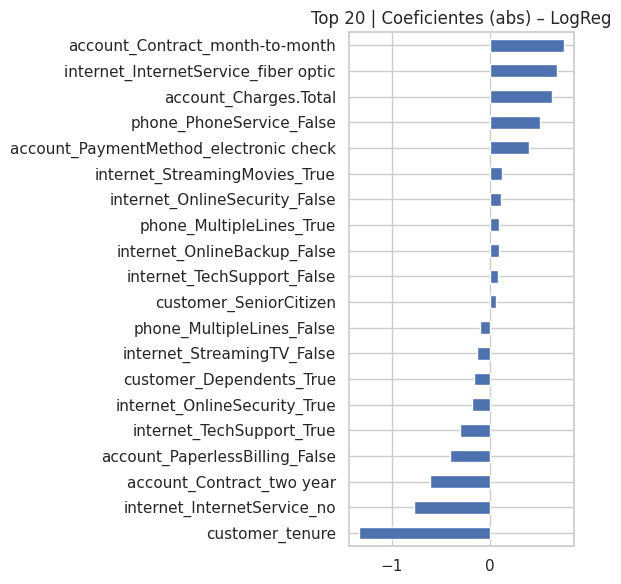

,0
account_Contract_month-to-month,0.177936
customer_tenure,0.142081
account_Charges.Total,0.098181
account_Charges.Monthly,0.084881
account_Contract_two year,0.083151
internet_InternetService_fiber optic,0.063329
account_PaymentMethod_electronic check,0.043774
internet_InternetService_no,0.039241
account_Contract_one year,0.029440
internet_InternetService_dsl,0.018676


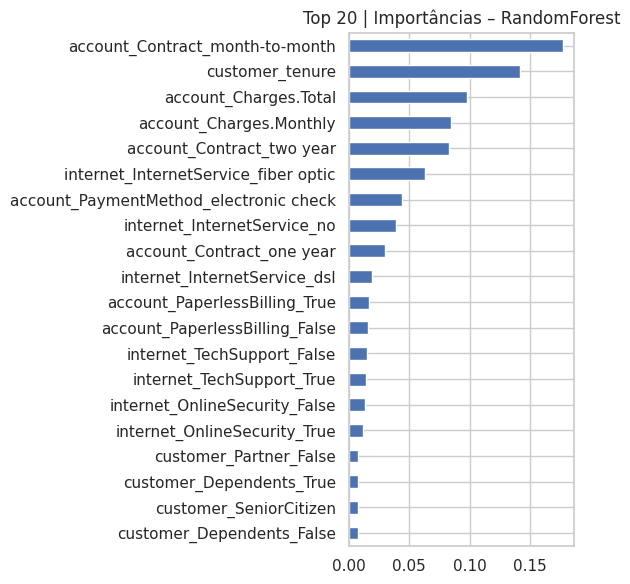

In [68]:
# Recuperar nomes das features pós OneHot
oh = gs_lr.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
num_names = num_cols
cat_names = oh.get_feature_names_out(cat_cols).tolist()
feature_names = list(num_names) + cat_names

# Coeficientes da LogReg (absolutos)
lr = gs_lr.best_estimator_.named_steps['model']
if hasattr(lr, 'coef_'):
    coefs = pd.Series(lr.coef_[0], index=feature_names).sort_values(key=lambda s: s.abs(), ascending=False)
    display(coefs.head(20))
    coefs.head(20).sort_values().plot(kind='barh', figsize=(6,6))
    plt.title('Top 20 | Coeficientes (abs) – LogReg')
    plt.tight_layout(); plt.show()

# Importâncias do RF
rf = gs_rf.best_estimator_.named_steps['model']
if hasattr(rf, 'feature_importances_'):
    imps = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
    display(imps.head(20))
    imps.head(20).sort_values().plot(kind='barh', figsize=(6,6))
    plt.title('Top 20 | Importâncias – RandomForest')
    plt.tight_layout(); plt.show()

## 11. Curva Precision‑Recall e **tuning de limiar** (ex.: buscar `Recall ≥ 0.80`)

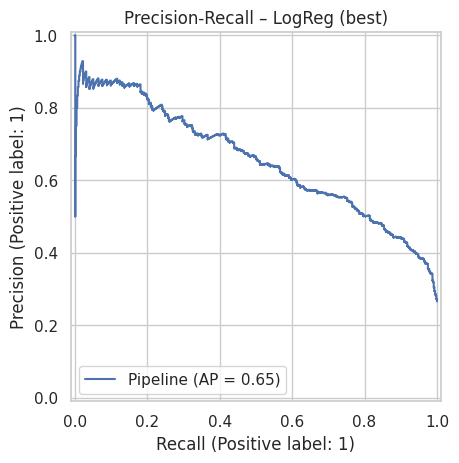

Limiar escolhido: 0.004 (alvo Recall ≥ 0.80)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1552
           1      0.265     1.000     0.420       561

    accuracy                          0.265      2113
   macro avg      0.133     0.500     0.210      2113
weighted avg      0.070     0.265     0.111      2113



In [69]:
def tune_threshold_for_recall(model, X_test, y_test, recall_target=0.80):
    proba = model.predict_proba(X_test)[:,1]
    prec, rec, thr = precision_recall_curve(y_test, proba)
    # Encontrar primeiro limiar que atinge recall alvo
    import numpy as np
    idx = np.argmax(rec >= recall_target)
    if idx == 0 and rec[0] < recall_target:
        print('Não foi possível atingir o recall alvo com os limiares padrão.')
        return None
    thr_star = thr[max(idx-1, 0)]
    y_thr = (proba >= thr_star).astype(int)
    print(f'Limiar escolhido: {thr_star:.3f} (alvo Recall ≥ {recall_target:.2f})')
    print(classification_report(y_test, y_thr, digits=3))
    return thr_star

PrecisionRecallDisplay.from_estimator(gs_lr.best_estimator_, X_test, y_test)
plt.title('Precision‑Recall – LogReg (best)')
plt.show()

_ = tune_threshold_for_recall(gs_lr.best_estimator_, X_test, y_test, recall_target=0.80)

## 12.  **SMOTE** dentro de Pipeline

SMOTE disponível – treinando LogReg com SMOTE dentro do CV...
SMOTE LR best AUC: 0.8452187778222479 | params: {'model__C': 0.1, 'model__penalty': 'l1'}

=== Desempenho no TESTE (SMOTE + LogReg) ===
LogReg + SMOTE (best): ACC=0.748 | PREC=0.517 | REC=0.790 | F1=0.625 | AUC=0.839

Classification report:
               precision    recall  f1-score   support

           0      0.906     0.733     0.811      1552
           1      0.517     0.790     0.625       561

    accuracy                          0.748      2113
   macro avg      0.711     0.761     0.718      2113
weighted avg      0.803     0.748     0.761      2113



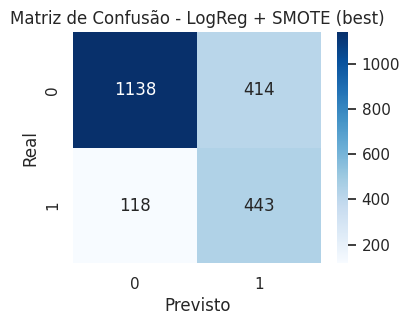

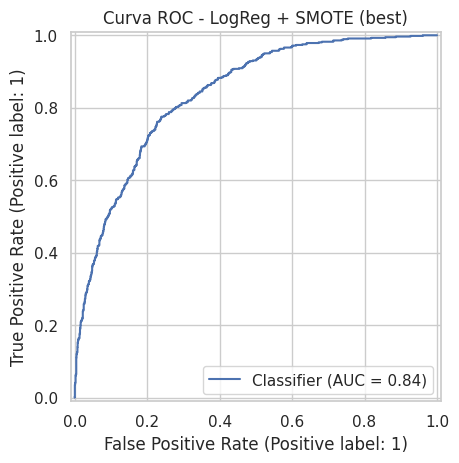

In [70]:
HAS_IMB = True
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
except Exception:
    HAS_IMB = False

if HAS_IMB:
    print('SMOTE disponível – treinando LogReg com SMOTE dentro do CV...')

    imb_pipe_lr = ImbPipeline(steps=[
        ('preprocess', preprocess),            # 1) transforma para numérico
        ('smote', SMOTE(random_state=RANDOM_STATE)),  # 2) aplica SMOTE
        ('model', LogisticRegression(max_iter=200, solver='liblinear', random_state=RANDOM_STATE)) # 3) modela
    ])

    imb_gs_lr = GridSearchCV(
        imb_pipe_lr, param_lr, scoring='roc_auc', cv=cv,
        n_jobs=-1, verbose=0, error_score='raise'
    )
    imb_gs_lr.fit(X_train, y_train)
    print('SMOTE LR best AUC:', imb_gs_lr.best_score_, '| params:', imb_gs_lr.best_params_)

    print('\n=== Desempenho no TESTE (SMOTE + LogReg) ===')
    evaluate(imb_gs_lr.best_estimator_, X_test, y_test, 'LogReg + SMOTE (best)')
else:
    print('SMOTE indisponível – instale imbalanced-learn para esta seção.')
